In [5]:
import pandas as pd
import numpy as np
import random
import pickle
import sys
import os
import logging
from os.path import join
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
#from hyperopt import fmin, tpe, hp, Trials, rand
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('CCB_plot_style_0v4.mplstyle');
c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']


Bad key text.latex.preview in file CCB_plot_style_0v4.mplstyle, line 55 ('text.latex.preview  : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file CCB_plot_style_0v4.mplstyle, line 63 ('mathtext.fallback_to_cm : True ## When True, use symbols from the Computer Modern fonts')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


## 1. Loading and preprocessing data for model training and evaluation

### (a) Loading data: 

In [6]:
data_train = pd.read_pickle(join("..", "..", "data", "substrate_classes",  "df_train.pkl"))
data_test = pd.read_pickle(join("..", "..", "data", "substrate_classes",  "df_test.pkl"))

data_train.reset_index(inplace = True, drop = True)
data_test.reset_index(inplace = True, drop = True)

In [7]:
len(data_train) + len(data_test), len(data_test)

(11664, 2333)

In [8]:
train_indices = np.load(join("..", "..", "data", "substrate_classes","splits", "CV_train_indices_categories.npy"), allow_pickle = True)
test_indices = np.load(join("..", "..", "data", "substrate_classes", "splits", "CV_test_indices_categories.npy"), allow_pickle = True)

## 2. Hyperparameter optimization ESM-1b vectors

#### (i) Creating numpy arrays with input vectors and output variables

In [9]:
categories = ["anion", "cation", "sugar", "amino acid" , "protein", "electron", "other"]
c_to_y ={"anion" : 0, "cation" : 1, "sugar": 2, "amino acid" : 3, "protein" : 4, "electron" : 5, "other" : 6}

In [10]:
for categorie in categories:
    print("%s : %s"  % (categorie, sum(data_train[categorie])))

anion : 625
cation : 6914
sugar : 350
amino acid : 282
protein : 105
electron : 77
other : 978


In [11]:
for categorie in categories:
    print("%s : %s"  % (categorie, sum(data_test[categorie])))

anion : 133
cation : 1709
sugar : 93
amino acid : 70
protein : 35
electron : 25
other : 268


In [12]:
data_train["outcome"] = np.nan

for ind in data_train.index:
    c = np.array(categories)[np.array(data_train[categories].loc[ind]) == 1][0]
    data_train["outcome"][ind] = c_to_y[c]
    
    
data_test["outcome"] = np.nan

for ind in data_test.index:
    c = np.array(categories)[np.array(data_test[categories].loc[ind]) == 1][0]
    data_test["outcome"][ind] = c_to_y[c]

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [13]:
len(data_train), len(data_test), len(data_train) + len(data_test)

(9331, 2333, 11664)

In [14]:
def create_input_and_output_data(df):
    X = ();
    y = ();
    
    for ind in df.index:
        X = X +(df["ESM1b"][ind], );
        y = y + (int(df["outcome"][ind]), );
    return(X,y)

train_X, train_y =  create_input_and_output_data(df = data_train)
test_X, test_y =  create_input_and_output_data(df = data_test)


feature_names = ["ESM1b_" + str(i) for i in range(1280)]

train_X = np.array(train_X)
test_X  = np.array(test_X)

train_y = np.array(train_y)
test_y  = np.array(test_y)

#### (ii) Performing hyperparameter optimization

In [15]:
'''def cross_validation_neg_acc_gradient_boosting(param):
    num_round = param["num_rounds"]
    param["tree_method"] = "gpu_hist"
    param["sampling_method"] = "gradient_based"
    param['objective'] = 'multi:softmax'
    param["num_class"] = 7
    param['eval_metric'] = 'mlogloss'
    del param["num_rounds"]
    
    acc = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(np.array(train_X[train_index]),
                         label = np.array(train_y[train_index]))
        dvalid = xgb.DMatrix(np.array(train_X[test_index]))
        bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
        y_valid_pred = np.round(bst.predict(dvalid))
        validation_y = train_y[test_index]
    
        acc.append(np.mean(y_valid_pred == np.array(validation_y)))
    return(-np.mean(acc))

#Defining search space for hyperparameter optimization
space_gradient_boosting = {"learning_rate": hp.uniform("learning_rate", 0.01, 0.5),
    "max_depth": hp.choice("max_depth", [7,8,9,10,11,12,13]),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 200, 400)}''';

#### (iii) Performing a random grid search:

In [16]:
'''trials = Trials()

for i in range(1,2000):
    best = fmin(fn = cross_validation_neg_acc_gradient_boosting, space = space_gradient_boosting,
                algo = rand.suggest, max_evals = i, trials = trials)
    np.save(join(CURRENT_DIR, ".." ,"data", "results", "cross_validation_binding_ESM1b.npy"), trials.best_trial)
    np.save(join(CURRENT_DIR, ".." ,"data", "results", "cross_validation_binding_ESM1b_argmin.npy"), trials.argmin)
    logging.info(i)
    logging.info(trials.best_trial["result"]["loss"])
    logging.info(trials.argmin)''';

Best set of hyperparameters:

In [17]:
param = {'learning_rate': 0.2339095120993189,
         'max_delta_step': 4.992217561409725,
         'max_depth': 8,
         'min_child_weight': 1.3482539801691398,
         'num_rounds': 188.30943054415226,
         'reg_alpha': 0.018345192687114764,
         'reg_lambda': 4.059148989627829,
         'weight': 0.1541792686974357}

num_round = param["num_rounds"]
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
param['objective'] = 'multi:softmax'
param["num_class"] = 7
param['eval_metric'] = 'mlogloss'

del param["num_rounds"]
weight = param["weight"]
weights = np.array([param["weight"] if y == 1 else 1.0 for y in data_train["outcome"]])
del param["weight"]

In [18]:
'''acc = []
for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(np.array(train_X[train_index]), weight = weights[train_index],
                     label = np.array(train_y[train_index]))
    dvalid = xgb.DMatrix(np.array(train_X[test_index]))
    bst = xgb.train(param,  dtrain, int(num_round), verbose_eval=1)
    y_valid_pred = np.round(bst.predict(dvalid))
    validation_y = train_y[test_index]

    acc.append(np.mean(y_valid_pred == np.array(validation_y)))
    
print(acc)''';


dtrain = xgb.DMatrix(np.array(train_X), label = np.array(train_y))
dtest = xgb.DMatrix(np.array(test_X), label = np.array(test_y))

evallist = [(dtest, 'eval'), (dtrain, 'train')]

bst = xgb.train(param,  dtrain, int(num_round), evallist)

y_test_pred = np.round(bst.predict(dtest))
acc_test = np.mean(y_test_pred == np.array(test_y))

print(acc_test)

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\xgboost\core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


[0]	eval-mlogloss:1.34083	train-mlogloss:1.30741
[1]	eval-mlogloss:1.04593	train-mlogloss:0.99187
[2]	eval-mlogloss:0.84890	train-mlogloss:0.77817
[3]	eval-mlogloss:0.70688	train-mlogloss:0.62206
[4]	eval-mlogloss:0.60158	train-mlogloss:0.50564
[5]	eval-mlogloss:0.51664	train-mlogloss:0.41267
[6]	eval-mlogloss:0.45063	train-mlogloss:0.33919
[7]	eval-mlogloss:0.39754	train-mlogloss:0.27975
[8]	eval-mlogloss:0.35482	train-mlogloss:0.23219
[9]	eval-mlogloss:0.32147	train-mlogloss:0.19513
[10]	eval-mlogloss:0.29380	train-mlogloss:0.16434
[11]	eval-mlogloss:0.26952	train-mlogloss:0.13827
[12]	eval-mlogloss:0.25115	train-mlogloss:0.11696
[13]	eval-mlogloss:0.23611	train-mlogloss:0.09953
[14]	eval-mlogloss:0.22294	train-mlogloss:0.08558
[15]	eval-mlogloss:0.21228	train-mlogloss:0.07340
[16]	eval-mlogloss:0.20344	train-mlogloss:0.06380
[17]	eval-mlogloss:0.19585	train-mlogloss:0.05564
[18]	eval-mlogloss:0.19038	train-mlogloss:0.04875
[19]	eval-mlogloss:0.18611	train-mlogloss:0.04283
[20]	eval-

[163]	eval-mlogloss:0.14531	train-mlogloss:0.00153
[164]	eval-mlogloss:0.14529	train-mlogloss:0.00152
[165]	eval-mlogloss:0.14526	train-mlogloss:0.00151
[166]	eval-mlogloss:0.14529	train-mlogloss:0.00150
[167]	eval-mlogloss:0.14531	train-mlogloss:0.00150
[168]	eval-mlogloss:0.14528	train-mlogloss:0.00149
[169]	eval-mlogloss:0.14526	train-mlogloss:0.00148
[170]	eval-mlogloss:0.14525	train-mlogloss:0.00147
[171]	eval-mlogloss:0.14522	train-mlogloss:0.00147
[172]	eval-mlogloss:0.14523	train-mlogloss:0.00146
[173]	eval-mlogloss:0.14529	train-mlogloss:0.00145
[174]	eval-mlogloss:0.14531	train-mlogloss:0.00145
[175]	eval-mlogloss:0.14545	train-mlogloss:0.00144
[176]	eval-mlogloss:0.14548	train-mlogloss:0.00143
[177]	eval-mlogloss:0.14544	train-mlogloss:0.00143
[178]	eval-mlogloss:0.14537	train-mlogloss:0.00142
[179]	eval-mlogloss:0.14533	train-mlogloss:0.00141
[180]	eval-mlogloss:0.14534	train-mlogloss:0.00141
[181]	eval-mlogloss:0.14539	train-mlogloss:0.00140
[182]	eval-mlogloss:0.14527	tra

In [19]:
data_test["pred"] = y_test_pred

### Validation:

In [20]:
{"anion" : 0, "cation" : 1, "sugar": 2, "amino acid" : 3, "protein" : 4, "electron" : 5, "other" : 6}

{'anion': 0,
 'cation': 1,
 'sugar': 2,
 'amino acid': 3,
 'protein': 4,
 'electron': 5,
 'other': 6}

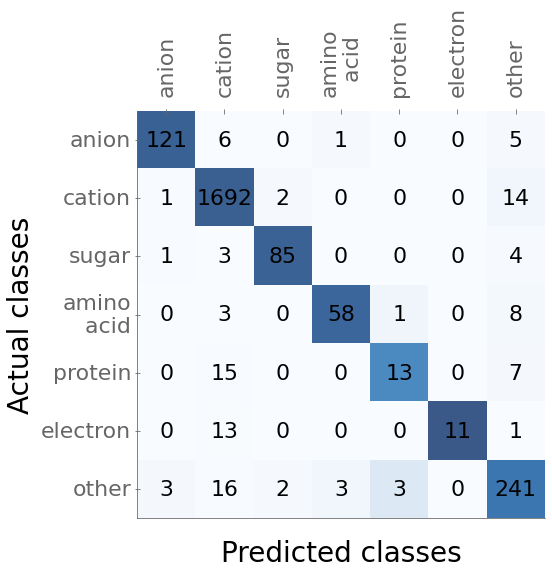

In [21]:
cross_matrix = np.zeros((8,8)).astype(int)
for c in range(7):
    class_vector = (test_y == c)
    pred_vector = y_test_pred[class_vector]
    for i in range(7):
        cross_matrix[c, i] = int(np.sum(pred_vector == i))
        
cross_matrix2 = cross_matrix.copy()

cross_matrix = np.zeros((7,7)).astype(float)
for c in range(7):
    class_vector = y_test_pred == c
    true_vector = test_y[class_vector]
    for i in range(7):
        cross_matrix[i, c] = float(np.sum(true_vector == i)) / sum(class_vector)
        

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cross_matrix, cmap=plt.cm.Blues, alpha=0.8)


        
        
        
ticks = np.array(list(range(7)))
labs = ['anion', 'cation', 'sugar', 'amino\n acid', 'protein', 'electron', 'other']
ax.set_xticks(ticks)
ax.set_xticklabels(labs,  y= 1.02, fontsize=22)
ax.tick_params(axis='x', rotation = 90, bottom = False)


ax.set_yticks(ticks)
ax.set_yticklabels(labs,  y= 1.02, fontsize=22)
ax.tick_params(axis='y', bottom = False)

for i in range(cross_matrix.shape[0]):
    for j in range(cross_matrix.shape[1]):
        ax.text(x=j, y=i,s=cross_matrix2[i, j], va='center', ha='center',  c = "black", fontsize = 22)

plt.xlabel('Predicted classes', fontsize=28)
plt.ylabel('Actual classes', fontsize=28)

ax.yaxis.set_label_coords(-0.25, 0.5)
ax.xaxis.set_label_coords(0.5,-0.05)

#plt.title('Confusion Matrix', fontsize=18)
plt.savefig(join("..", "..", "figures", "Confusion_matrix_substrate_class.svg"))
plt.show()

In [22]:
cross_matrix = np.zeros((8,8)).astype(int)
for c in range(7):
    class_vector = (test_y == c)
    pred_vector = y_test_pred[class_vector]
    for i in range(7):
        cross_matrix[c, i] = int(np.sum(pred_vector == i))
        
        
        
for i in range(7):
    cross_matrix[i, 7] = int(np.sum(cross_matrix[i, :]))
    cross_matrix[7, i] = int(np.sum(cross_matrix[:, i]))
cross_matrix

array([[ 121,    6,    0,    1,    0,    0,    5,  133],
       [   1, 1692,    2,    0,    0,    0,   14, 1709],
       [   1,    3,   85,    0,    0,    0,    4,   93],
       [   0,    3,    0,   58,    1,    0,    8,   70],
       [   0,   15,    0,    0,   13,    0,    7,   35],
       [   0,   13,    0,    0,    0,   11,    1,   25],
       [   3,   16,    2,    3,    3,    0,  241,  268],
       [ 126, 1748,   89,   62,   17,   11,  280,    0]])

Calculating per class performance:

In [52]:
categories = ["anion", "cation", "sugar", "amino acid" , "protein", "electron", "other"]
class_label = {"anion" : 0, "cation" : 1, "sugar": 2, "amino acid" : 3, "protein" : 4, "electron" : 5, "other" : 6}


for c in categories:
#c = categories[0]
    label = class_label[c]

    true_labels = np.array(data_test[c])
    pred_labels = np.array([label == data_test["pred"][ind] for ind in data_test.index]).astype(int)
    acc = np.mean(pred_labels ==true_labels)
    mcc = matthews_corrcoef(true_labels, pred_labels)
    TP = np.sum((true_labels == 1) & (pred_labels == 1))
    FP = np.sum((true_labels == 0) & (pred_labels == 1))
    TN = np.sum((true_labels == 0) & (pred_labels == 0))
    FN = np.sum((true_labels == 1) & (pred_labels == 0))
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    metrics = np.round(100*np.array([acc, mcc, specificity, sensitivity]), 2)
    
    
    #print("%s & %s\%% & %s\%% & %s\%% & %s\%%" %(c, metrics[0], metrics[1], metrics[2], metrics[3]))
    print("%s & %s\%% & %s" %(c, metrics[0], np.round(metrics[1]/100,2)))

anion & 99.27\% & 0.93
cation & 96.87\% & 0.92
sugar & 99.49\% & 0.93
amino acid & 99.31\% & 0.88
protein & 98.89\% & 0.53
electron & 99.4\% & 0.66
other & 97.17\% & 0.86


(0.9811138014527845, 0.8992537313432836)

In [19]:
data_test["ident_pred"] = np.nan
for ind in data_test.index:
    if not pd.isnull(data_test["max_ind"][ind]):
        data_test["ident_pred"][ind] = data_train["outcome"][data_test["max_ind"][ind]]

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


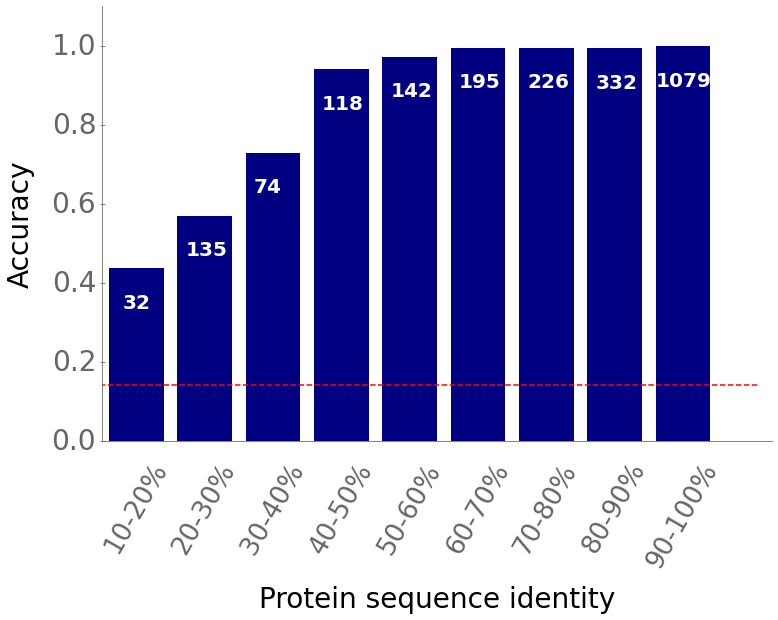

In [23]:
fig, ax = plt.subplots(figsize= (12,8))
plt.rcParams.update({'font.size': 28})

splits = ["10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]
lower_bound = [10,20,30,40,50,60,70,80,90]
upper_bound = [20,30,40,50,60,70,80,90,100]

accuracies = []
n_data_points = []
for i, split in enumerate(splits):
    help_df = data_test.loc[data_test["max_ident"]> lower_bound[i]]
    help_df = help_df.loc[help_df["max_ident"]<= upper_bound[i]]
    y_true = np.array(help_df["outcome"])
    y_pred = np.array(help_df["pred"])
    
    acc =  np.mean(y_pred == np.array(y_true))

    accuracies.append(acc)
    n_data_points.append(len(y_pred))
    
sub_bins = list(range(9))
    
plt.bar(sub_bins, height = accuracies,  color= "navy")

for i in range(9):
    if i ==0:
        ax.annotate(n_data_points[i], (i-0.2, accuracies[i]-0.1), fontsize=20, c= "white", weight = "bold")
    elif i ==8:
        ax.annotate(n_data_points[i], (i-0.4, accuracies[i]-0.1), fontsize=20, c= "white", weight = "bold")
    else:
        ax.annotate(n_data_points[i], (i-0.28, accuracies[i]-0.1), fontsize=20, c= "white", weight = "bold")


ticks2 = np.array(range(len(splits)))
labs = splits
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 60)

plt.ylim((0.0,1.1))
plt.xlim((-0.5, 9.3))
plt.ylabel('Accuracy')
plt.xlabel('Protein sequence identity')
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.xaxis.set_label_coords(0.5,-0.33)

sns.lineplot(x=[-1,9.1],y=[1/7,1/7], linestyle='--', color = "red")

plt.savefig(join("..", "..", "figures", "Accuracies_substrate_class.svg"))
plt.show()

In [21]:
help_df = data_test.loc[data_test["max_ident"]> 0]
help_df = help_df.loc[help_df["max_ident"]< 40]
y_true = np.array(help_df["outcome"])
y_pred = np.array(help_df["pred"])
n_kcat = len(y_pred)
acc =  np.mean(y_pred == np.array(y_true))
acc, n_kcat

(0.6016597510373444, 241)

Randomly sampling class labels for test data set:

In [22]:
from random import choices

accuracies = []
for i in range(10000):
    random_pred = choices(list(range(7)), k=len(data_test))
    accuracies.append(np.mean(random_pred == data_test["outcome"]))
np.mean(accuracies)

0.14280094299185597